In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

class TicTacToeEnv:
    def __init__(self, n=3):
        self.n = n
        self.board = np.zeros((n, n), dtype=int)
        self.reset()

    def reset(self):
        self.board = np.zeros((self.n, self.n), dtype=int)
        return self.board

    def available_actions(self):
        return [(i, j) for i in range(self.n) for j in range(self.n) if self.board[i, j] == 0]

    def make_move(self, row, col, player):
        if self.board[row, col] == 0:
            self.board[row, col] = player
            return True
        return False

    def check_winner(self):
        for i in range(self.n):
            if np.all(self.board[i, :] == 1) or np.all(self.board[:, i] == 1):
                return 1
            if np.all(self.board[i, :] == -1) or np.all(self.board[:, i] == -1):
                return -1

        if np.all(np.diag(self.board) == 1) or np.all(np.diag(np.fliplr(self.board)) == 1):
            return 1
        if np.all(np.diag(self.board) == -1) or np.all(np.diag(np.fliplr(self.board)) == -1):
            return -1

        if not any(0 in row for row in self.board):
            return 0

        return None

    def is_draw(self):
        return not any(0 in row for row in self.board)

    def get_state(self):
        return self.board.flatten()

class FeatureExtractor:
    def __init__(self, board):
        self.board = board
        self.n = board.shape[0]

    def count_features(self, symbol):
        features = np.zeros(self.n)

        for i in range(self.n):
            row = self.board[i, :]
            count = np.sum(row == symbol)
            if count > 0 and np.sum(row != symbol) == self.n - count:
                features[count - 1] += 1

        for j in range(self.n):
            col = self.board[:, j]
            count = np.sum(col == symbol)
            if count > 0 and np.sum(col != symbol) == self.n - count:
                features[count - 1] += 1

        diag1 = np.diag(self.board)
        count_diag1 = np.sum(diag1 == symbol)
        if count_diag1 > 0 and np.sum(diag1 != symbol) == self.n - count_diag1:
            features[count_diag1 - 1] += 1

        diag2 = np.diag(np.fliplr(self.board))
        count_diag2 = np.sum(diag2 == symbol)
        if count_diag2 > 0 and np.sum(diag2 != symbol) == self.n - count_diag2:
            features[count_diag2 - 1] += 1

        for i in range(self.n):
            features[i] *= (i + 1) ** 2

        return features

    def extract_features(self):
        agent_features = self.count_features(1)
        opponent_features = self.count_features(-1)
        features_matrix = np.array([agent_features, opponent_features]).flatten()

        board_state = self.board.flatten()

        combined_features = np.concatenate((features_matrix, board_state))

        return combined_features    

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, n=3, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.1, learning_rate=0.001):
        self.n = n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        input_size = (n+2)*n
        self.model = DQN(input_size=input_size, output_size=n * n)  
        self.target_model = DQN(input_size=input_size, output_size=n * n)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        self.memory = deque(maxlen=20000)
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        extractor = FeatureExtractor(state.reshape(self.n, self.n))
        features = torch.FloatTensor(extractor.extract_features()).unsqueeze(0)
        
        if random.uniform(0, 1) < self.epsilon:
            available_actions = [(i, j) for i in range(self.n) for j in range(self.n) if state[i * self.n + j] == 0]
            return random.choice(available_actions)
        else:
            q_values = self.model(features).view(self.n, self.n)
            available_actions = [(i, j) for i in range(self.n) for j in range(self.n) if state[i * self.n + j] == 0]
            best_action = max(available_actions, key=lambda x: q_values[x[0], x[1]].item())
            return best_action

    def train(self, batch_size=64):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        features_states = torch.FloatTensor([FeatureExtractor(s.reshape(self.n, self.n)).extract_features() for s in states])
        features_next_states = torch.FloatTensor([FeatureExtractor(s.reshape(self.n, self.n)).extract_features() for s in next_states])
        
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)
        
        q_values = self.model(features_states)
        next_q_values = self.target_model(features_next_states)

        q_values = q_values.view(batch_size, self.n, self.n)

        target_q_values = q_values.clone()
        for i in range(batch_size):
            action = actions[i]
            target_q_values[i, action[0], action[1]] = rewards[i] + (1 - dones[i]) * self.gamma * next_q_values[i].max().item()

        loss = self.criterion(q_values.view(batch_size, -1), target_q_values.view(batch_size, -1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay
            
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))
        self.update_target_network()

def train_dqn(agent, env, episodes=1000, target_update=10):
    for episode in range(episodes):
        state = env.reset().flatten()
        done = False
        while not done:
            action = agent.choose_action(state)
            env.make_move(action[0], action[1], 1)
            next_state = env.get_state()
            reward = 0
            winner = env.check_winner()

            if winner == 1:
                reward = 1
                done = True
            elif env.is_draw():
                reward = 0
                done = True
            else:
                available_actions = env.available_actions()
                if available_actions:
                    random_action = random.choice(available_actions)
                    env.make_move(random_action[0], random_action[1], -1)
                    winner = env.check_winner()
                    next_state = env.get_state()
                    
                    if winner == -1:
                        reward = -1
                        done = True
                    elif env.is_draw():
                        reward = 0
                        done = True
                    else:
                        reward = 0

            agent.store_transition(state, action, reward, next_state, done)
            state = next_state

            if done:
                agent.train(batch_size=64)

        if episode % target_update == 0:
            agent.update_target_network()
        if episode % (episodes//10) == 0:
            print(f"Episode {episode + 1}/{episodes}")
env = TicTacToeEnv()
agent = DQNAgent()

train_dqn(agent, env, episodes=10000)


Episode 1/10000


/tmp/ipykernel_17/2461167333.py:151: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  features_states = torch.FloatTensor([FeatureExtractor(s.reshape(self.n, self.n)).extract_features() for s in states])


Episode 1001/10000
Episode 2001/10000
Episode 3001/10000
Episode 4001/10000
Episode 5001/10000
Episode 6001/10000
Episode 7001/10000
Episode 8001/10000
Episode 9001/10000


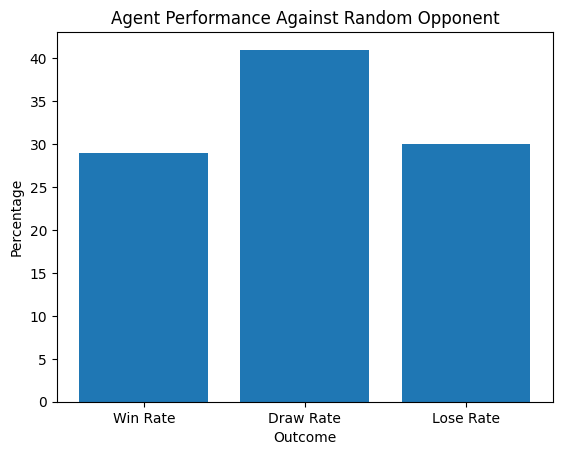

Win Rate: 29.00% | Draw Rate: 41.00% | Lose Rate: 30.00


In [3]:

def test_agent(agent, env, test_episodes=100):
    win, draw, lose = 0, 0, 0
    for episode in range(test_episodes):
        state = env.reset().flatten()
        done = False
        while not done:
            action = agent.choose_action(state)
            env.make_move(action[0], action[1], 1)
            next_state = env.get_state()
            winner = env.check_winner()
            if winner == 1:
                win += 1
                done = True
            elif env.is_draw():
                draw += 1
                done = True

            if not done:
                available_actions = env.available_actions()
                if available_actions:
                    random_action = random.choice(available_actions)
                    env.make_move(random_action[0], random_action[1], -1)
                    winner = env.check_winner()
                    if winner == -1:
                        lose += 1
                        done = True
                    elif env.is_draw():
                        draw += 1
                        done = True

            state = next_state

    total_games = win + draw + lose
    win_rate = win / total_games * 100
    draw_rate = draw / total_games * 100
    lose_rate = lose / total_games * 100

    results = {'Win Rate': win_rate, 'Draw Rate': draw_rate, 'Lose Rate': lose_rate}
    plt.bar(results.keys(), results.values())
    plt.xlabel('Outcome')
    plt.ylabel('Percentage')
    plt.title('Agent Performance Against Random Opponent')
    plt.show()

    print(f"Win Rate: {win_rate:.2f}% | Draw Rate: {draw_rate:.2f}% | Lose Rate: {lose_rate:.2f}")
    
test_agent(agent, env, test_episodes=100)

Episode 1/10000
Episode 1001/10000
Episode 2001/10000
Episode 3001/10000
Episode 4001/10000
Episode 5001/10000
Episode 6001/10000
Episode 7001/10000
Episode 8001/10000
Episode 9001/10000


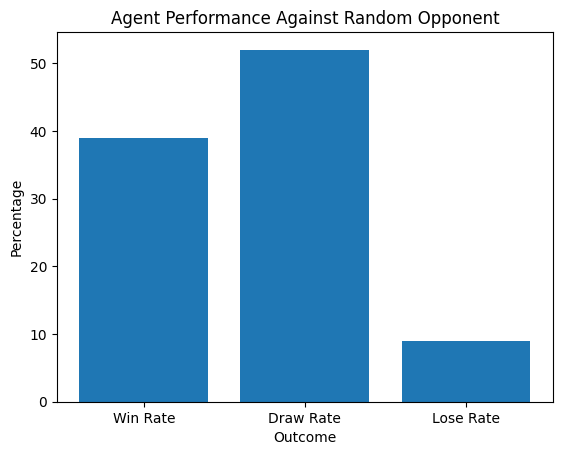

Win Rate: 39.00% | Draw Rate: 52.00% | Lose Rate: 9.00


In [4]:
env = TicTacToeEnv(n=4)
agent = DQNAgent(n=4)

train_dqn(agent, env, episodes=10000)
test_agent(agent, env, test_episodes=100)

Episode 1/10000
Episode 1001/10000
Episode 2001/10000
Episode 3001/10000
Episode 4001/10000
Episode 5001/10000
Episode 6001/10000
Episode 7001/10000
Episode 8001/10000
Episode 9001/10000


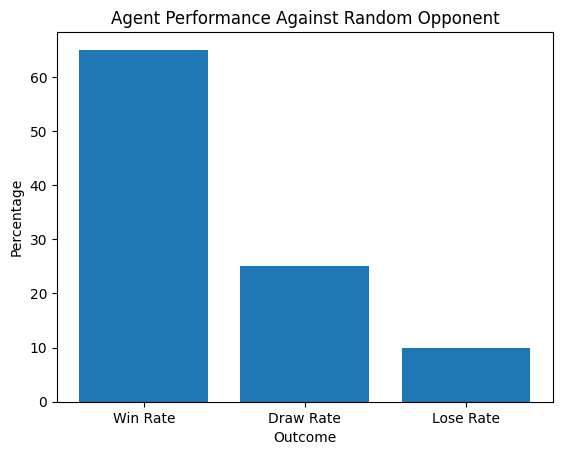

Win Rate: 65.00% | Draw Rate: 25.00% | Lose Rate: 10.00


In [5]:
env = TicTacToeEnv(n=5)
agent = DQNAgent(n=5)

train_dqn(agent, env, episodes=10000)
test_agent(agent, env, test_episodes=100)